In [1]:
import util_mjw.Simulation as Gsim
import util_mjw.RotRep as Rot
import numpy as np
import matplotlib.pyplot as plt
from util_mjw.config import Config
import os
from util_mjw.calibration_misc import data_prep,optimize_detector,find_grains,write_config_files,fetch_images
import yaml
import h5py

# Extract the windows around the Bragg Peaks from a small grain

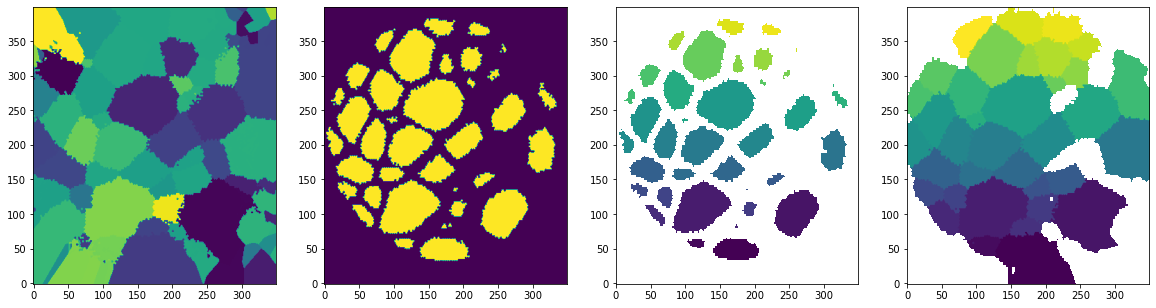

Number of Grains: 36


In [2]:
Cfg = Config('Config_Files/Config.yml')
Num_Grains = find_grains(Cfg,0.8)

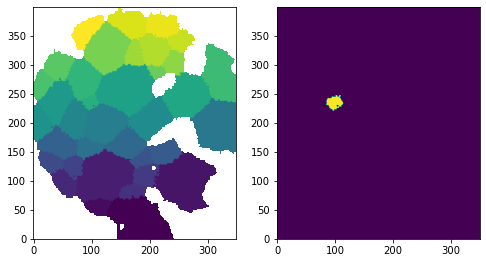

In [3]:
############ Choose grain to use for calibration ##########
grain_ID = 23
  
#######################################################3
microstructure = np.array(h5py.File(Cfg.micFile,'r')['GrainID'])
calib_grain = np.where(microstructure==grain_ID,1,0)
microstructure = np.where(microstructure==0,np.nan,np.float32(microstructure))
fig,ax = plt.subplots(ncols=2,figsize=(8,5))
ax[0].imshow(microstructure,origin='lower')
ax[1].imshow(calib_grain,origin='lower')
plt.show()

grain = Config(f'Config_Files/Grain_Files/Grain_%03d.yml'%grain_ID)

# Find the Center of Mass of each Bragg Peak

In [4]:
path = 'Calibration_Files/'
center_of_mass,goodidx = data_prep(Cfg,grain,path)

thresholding
removing hot spots
smoothing


# Start Calibration

In [5]:
x,oldPs,newPs,absCOM,goodidx = optimize_detector(center_of_mass,goodidx,grain,cutoff=[60,30,10])
dist0 = np.absolute(np.linalg.norm(oldPs-absCOM,axis=1)).mean()
dist1 = np.absolute(np.linalg.norm(newPs-absCOM,axis=1)).mean()
print('average pixel error before:',dist0)
print('average pixel error after:',dist1)
print('number of peaks used:',len(oldPs))


25.927813005734357
0.17518576451504075
0.2658839767187463
-3.247779578241213
average pixel error before: 4.012123078222943
average pixel error after: 1.0208435589858604
number of peaks used: 86


# Check the position of simulated Bragg peaks after calibration

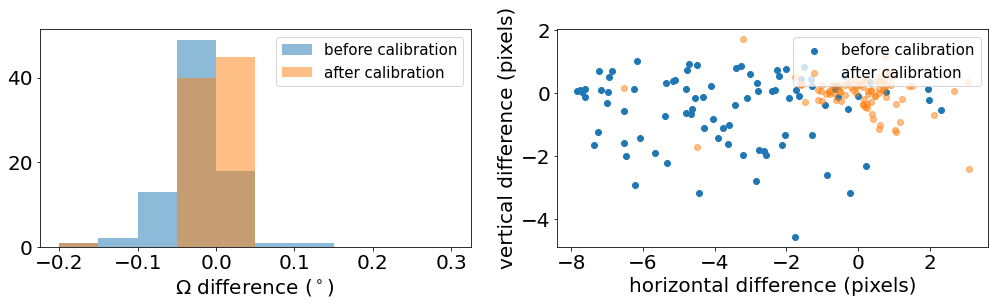

In [6]:
fig,ax=plt.subplots(1,2,figsize=(17,4))
ax[0].hist(oldPs[:,2]-absCOM[:,2],label='before calibration',bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
ax[0].hist(newPs[:,2]-absCOM[:,2],label='after calibration',bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
ax[0].legend(loc='upper right', fontsize=15)
ax[0].set_xlabel(r'$\Omega$ difference $(^\circ)$', fontsize=20)
ax[1].scatter(oldPs[:,0]-absCOM[:,0],oldPs[:,1]-absCOM[:,1],label='before calibration')
ax[1].scatter(newPs[:,0]-absCOM[:,0],newPs[:,1]-absCOM[:,1],label='after calibration',alpha=0.5)
ax[1].set_xlabel('horizontal difference (pixels)', fontsize=20)
ax[1].set_ylabel('vertical difference (pixels)', fontsize=20)
ax[1].legend(loc='upper right', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
plt.savefig('calibration.png',dpi=100,bbox_inches='tight')
plt.show()

# Write new parameters to config files

In [7]:
x = list([float(xx) for xx in x])
write_config_files(x,Num_Grains)

# Make peak files for all grains

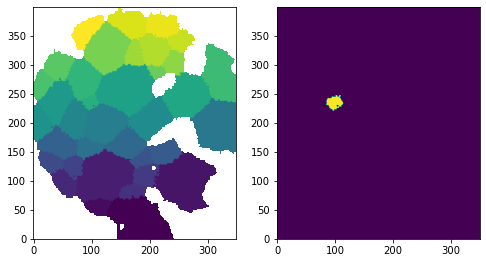

23
thresholding
removing hot spots
smoothing


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.235336876224418
103 85
68.0 seconds


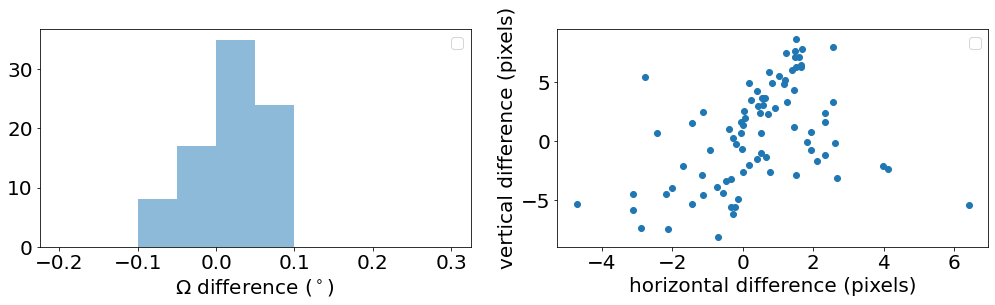

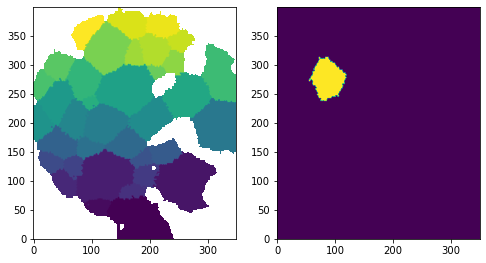

24
thresholding
removing hot spots
smoothing


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.08548320255386871
96 80
65.0 seconds


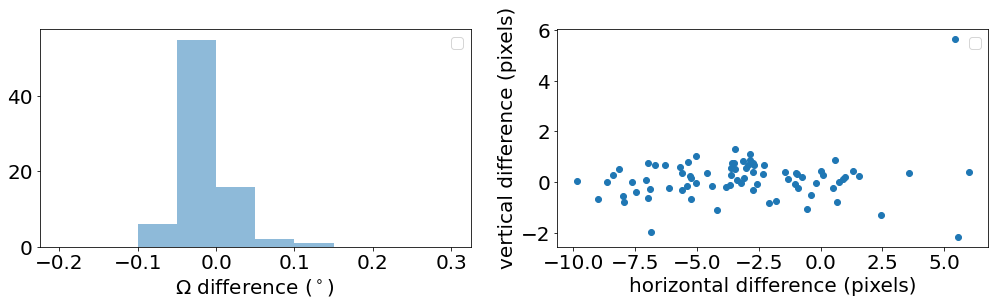

In [9]:
import time
from util_mjw.calibration_misc import optimize_distortion
for g in range(23,25):
    
    calib_grain = np.where(microstructure==g,1,0)
    microstructure = np.where(microstructure==0,np.nan,np.float32(microstructure))
    fig,ax = plt.subplots(ncols=2,figsize=(8,5))
    ax[0].imshow(microstructure,origin='lower')
    ax[1].imshow(calib_grain,origin='lower')
    plt.show()
    start = time.time()
    print(g)
    grain = Config(f'Config_Files/Grain_Files/Grain_%03d.yml'%g)
    path = 'Peak_Files/'
    center_of_mass,goodidx = data_prep(Cfg,grain,path)
    x,pks,absCOM,Gs,Info = optimize_distortion(Cfg,grain,center_of_mass,path)
    print(np.linalg.det(x.reshape(3,3)))
    dists = np.absolute(np.linalg.norm(pks-absCOM,axis=1))
    inds = np.where(dists<10)
    goodidx = goodidx[inds]
    center_of_mass = center_of_mass[goodidx]
    
    print(len(dists),len(dists[goodidx]))
    end = time.time()
    print(np.round(end-start),'seconds')

    fig,ax=plt.subplots(1,2,figsize=(17,4))
    pks = pks[goodidx]
    absCOM = absCOM[goodidx]
    ax[0].hist(pks[:,2]-absCOM[:,2],bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
    ax[0].legend(loc='upper right', fontsize=15)
    ax[0].set_xlabel(r'$\Omega$ difference $(^\circ)$', fontsize=20)
    ax[1].scatter(pks[:,0]-absCOM[:,0],pks[:,1]-absCOM[:,1])
    ax[1].set_xlabel('horizontal difference (pixels)', fontsize=20)
    ax[1].set_ylabel('vertical difference (pixels)', fontsize=20)
    ax[1].legend(loc='upper right', fontsize=15)
    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=20)
    plt.savefig('calibration.png',dpi=100,bbox_inches='tight')
    plt.show()

    imgN = len(goodidx)
    peakMap = np.zeros((Cfg.window[1],Cfg.window[0],Cfg.window[2]*imgN),dtype=np.uint16)
    LimH = np.empty((imgN,5),dtype=np.int32)
    Gs_good = Gs[goodidx]
    whichOmega = np.empty(imgN,dtype=np.int32)



    avg_distortion = x.reshape((3,3))
    MaxInt = np.empty(imgN,dtype=np.float32)

    for ii in range(imgN):
        limit=np.load(path+'grain_%03d/RawImgData/limit_%03d.npy'%(g,goodidx[ii]))
        img = np.load(path+'grain_%03d/FilteredImgData/Im_%03d.npy'%(g,goodidx[ii]))
        peakMap[:img.shape[1],:img.shape[2],ii * Cfg.window[2]:(ii + 1) * Cfg.window[2]] = np.moveaxis(img,0,-1)
        LimH[ii,:]=limit[0]
        MaxInt[ii]=np.max(img)
        if Info[goodidx[ii]]['WhichOmega']=='b':
            whichOmega[ii] = 2
        else:
            whichOmega[ii] = 1


    orien=Rot.EulerZXZ2Mat(np.array(grain.euler)/180.0*np.pi)
    with h5py.File(grain.peakFile, 'w') as f:
        f.create_dataset("limits", data=LimH)
        f.create_dataset("Gs", data=Gs_good)
        f.create_dataset("whichOmega", data=whichOmega)
        f.create_dataset("Pos", data=grain.grainPos)
        f.create_dataset("OrienM", data=orien)
        f.create_dataset("avg_distortion", data=avg_distortion)
        f.create_dataset("MaxInt", data=MaxInt)

        grp = f.create_group('Imgs')
        for ii in range(imgN):
            grp.create_dataset('Im{0:d}'.format(ii), data=peakMap[:,:,ii * Cfg.window[2]:(ii + 1) * Cfg.window[2]])

In [ ]:
print(np.linalg.det(x.reshape(3,3)))

In [ ]:
pp = np.floor(pks)
ppp = np.floor(Ps)

pp==ppp

In [ ]:
print(x[6]*1e-3,x[7]*1e-3)